In [1]:
import numpy as np
from torch.utils.tensorboard.writer import SummaryWriter
from torch import optim
import torch
import os

%load_ext autoreload
%autoreload 2
import env
import network
import player

BOARD_XSIZE=7
BOARD_YSIZE=6
DIMS=(BOARD_YSIZE,BOARD_XSIZE)

EPISODES_PER_AGENT = 100
TRAIN_EPOCHS = 500000
MODEL_SAVE_INTERVAL = 100
SUMMARY_STATS_INTERVAL = 10
RANDOM_SEED = 42

SUMMARY_DIR = './summary'
MODEL_DIR = './models'

# create result directory
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)


use_cuda = torch.cuda.is_available()
torch.manual_seed(RANDOM_SEED)

cuda = torch.device("cuda")
cpu = torch.device("cpu")

if use_cuda:
    device = cuda
else:
    device = cpu


2023-06-04 14:13:56.420832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 14:13:57.530035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
actor = network.Actor(BOARD_XSIZE, BOARD_YSIZE).to(device)
critic = network.Critic(BOARD_XSIZE, BOARD_YSIZE).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=network.ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=network.CRITIC_LR)

# Get Writer
writer = SummaryWriter(log_dir=SUMMARY_DIR)

step=0

In [3]:
opponent_pool:list[player.Player] = [
    player.RandomPlayer(env.PLAYER2),
    player.MinimaxPlayer(env.PLAYER2, 2, 0.1),
    player.MinimaxPlayer(env.PLAYER2, 2, 0.3),
    player.MinimaxPlayer(env.PLAYER2, 2, 0.5),
]

rewards_vs: dict[str, list[float]] = {}

In [4]:
def play(actor:player.ActorPlayer, opponent: player.Player, actor_turn:bool) -> tuple[
    list[env.Observation],
    list[env.Action],
    list[env.Reward],
    list[env.Advantage],
    list[env.Reward],
]:
    e = env.Env(DIMS)

    s_t:list[env.Observation] = []
    a_t:list[env.Action] = []
    r_t:list[env.Reward] = []
    # play the game
    while not e.game_over():
        if actor_turn:
            obs, chosen_action, reward = actor.play(e)
            s_t += [obs]
            a_t += [chosen_action]
            r_t += [reward]
        else:
            opponent.play(e)

        # flip turn
        actor_turn = not actor_turn

    # compute advantage and value
    d_t = network.compute_advantage(actor.critic, s_t, r_t)
    v_t = network.compute_value(r_t)

    return s_t, a_t, r_t, d_t, v_t

In [14]:
# interrupt this cell when you're done training

for _ in range(TRAIN_EPOCHS):
    s_batch:list[env.Observation] = []
    a_batch:list[env.Action] = []
    p_batch:list[np.ndarray] = []
    d_batch:list[env.Advantage] = []
    v_batch:list[env.Value] = []
    
    # create actor player
    actor_player = player.ActorPlayer(actor, critic, step, env.PLAYER1)
    
    for _ in range(EPISODES_PER_AGENT):
        # pick a random opponent
        opponent_player = opponent_pool[np.random.randint(len(opponent_pool))]

        # whether we or our opponent goes first
        go_first = np.random.randint(2) == 0

        # play the game
        s_t, a_t, r_t, d_t, v_t = play(actor_player,opponent_player, go_first)

        # now update the minibatch
        s_batch += s_t
        a_batch += a_t
        d_batch += d_t
        v_batch += v_t

        # statistics
        opp_name = opponent_player.name()
        if opp_name in rewards_vs:
            rewards_vs[opp_name].append(float(v_t[-1]))
        else:
            rewards_vs[opp_name] = [float(v_t[-1])]

    actor_losses, critic_losses = network.train_ppo(
        actor,
        critic,
        actor_optimizer,
        critic_optimizer,
        s_batch,
        a_batch,
        d_batch,
        v_batch
    )

    for actor_loss, critic_loss in zip(actor_losses, critic_losses):
        writer.add_scalar('actor_loss', actor_loss, step)
        writer.add_scalar('critic_loss', critic_loss, step)

        if step % SUMMARY_STATS_INTERVAL == 0:
            for opponent_name, rewards in rewards_vs.items():
                if len(rewards) > 50:
                    avg_reward = np.array(rewards).mean()
                    writer.add_scalar(f'reward_against_{opponent_name}', avg_reward, step)
                    rewards_vs[opponent_name] = []

        if step % MODEL_SAVE_INTERVAL == 0:
            # Save the neural net parameters to disk.
            torch.save(actor.state_dict(), f"{SUMMARY_DIR}/nn_model_ep_{step}_actor.ckpt")
            torch.save(critic.state_dict(), f"{SUMMARY_DIR}/nn_model_ep_{step}_critic.ckpt")
        
        step += 1

KeyboardInterrupt: 

In [ ]:
actor.load_state_dict(torch.load('./summary/nn_model_ep_500_actor.ckpt'))
#critic.load_state_dict(torch.load('./summary/nn_model_ep_1500_critic.ckpt'))

In [15]:
e = env.Env(DIMS)

e.step(env.Action(1), env.PLAYER1)
e.step(env.Action(1), env.PLAYER1)
e.step(env.Action(1), env.PLAYER1)

e.step(env.Action(5), env.PLAYER2)
e.step(env.Action(5), env.PLAYER2)
e.step(env.Action(5), env.PLAYER2)



o = e.observe(1)
print(e.legal_mask())
env.print_obs(o)
print('0 1 2 3 4 5 6 7')
print(actor.forward(network.obs_to_tensor(o, device))[0])
print(critic.forward(network.obs_to_tensor(o, device))[0])

[ True  True  True  True  True  True  True]
              
              
              
  #       O   
  #       O   
  #       O   

0 1 2 3 4 5 6 7
tensor([0.0969, 0.1229, 0.1635, 0.2369, 0.1676, 0.1104, 0.1018],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4854, device='cuda:0', grad_fn=<SelectBackward0>)


In [6]:
# use this cell to observe some games from the network

s_tensor = network.obs_batch_to_tensor(s_batch, device)
critic_guesses = critic.forward(s_tensor).to(cpu).detach().numpy()
actor_guesses = actor.forward(s_tensor).to(cpu).detach().numpy()
for v, obs, critic_guess, actor_guess in zip(v_batch, s_batch, critic_guesses, actor_guesses):
    print("real_value", v)
    print("pred_value", float(critic_guess))
    print("actor_probs", np.array(actor_guess))
    env.print_obs(obs)
    print('0 1 2 3 4 5 6 7')

real_value 0.38742048900000015
pred_value 0.27768072485923767
actor_probs [0.06392293 0.10919538 0.15716156 0.21870019 0.19432788 0.13823684
 0.11845522]
              
              
              
              
              
          O   

0 1 2 3 4 5 6 7
real_value 0.43046721000000016
pred_value 0.33023807406425476
actor_probs [0.08303691 0.10415947 0.16067997 0.18534061 0.21512127 0.13838744
 0.11327432]
              
              
              
              
              
O     #   O   

0 1 2 3 4 5 6 7
real_value 0.47829690000000014
pred_value 0.41097503900527954
actor_probs [0.06910276 0.1084652  0.2131693  0.17966853 0.18190289 0.12640865
 0.12128268]
              
              
              
              
          O   
O     # # O   

0 1 2 3 4 5 6 7
real_value 0.5314410000000002
pred_value 0.42157334089279175
actor_probs [0.05579296 0.12400332 0.18704641 0.19916503 0.18433669 0.13161352
 0.11804201]
              
              
              
              
    

In [7]:
# Now you try!
e = env.Env(DIMS)

actor_turn = True
opponent = player.ActorPlayer(actor, critic, step, env.PLAYER2)
human_player = player.HumanPlayer(env.PLAYER1)
# minmax player with depth 3 and no randomness

while not e.game_over():
    if actor_turn:
        obs, chosen_action, reward = human_player.play(e)
    else:
        opponent.play(e)
    # flip turn
    actor_turn = not actor_turn

if e.winner() == env.PLAYER1:
    print("You win!")
elif e.winner() == env.PLAYER2:
    print("You lose!")
else:
    print("Draw!")

              
              
              
              
              
              

0 1 2 3 4 5 6
legal mask: [ True  True  True  True  True  True  True]
              
              
              
              
              
    O #       

0 1 2 3 4 5 6
legal mask: [ True  True  True  True  True  True  True]
              
              
              
      O       
      #       
    O #       

0 1 2 3 4 5 6
legal mask: [ True  True  True  True  True  True  True]
              
              
              
      O       
      #       
    O # # O   

0 1 2 3 4 5 6
legal mask: [ True  True  True  True  True  True  True]
              
              
              
      O       
    # #       
  O O # # O   

0 1 2 3 4 5 6
legal mask: [ True  True  True  True  True  True  True]


ValueError: invalid literal for int() with base 10: ''

### Testing the Value Network

In [20]:
s = []
r = []
d = []
t = []
v_true = []
v_pred = []

for _ in range(200):
    # whether we or our opponent goes first
    go_first = np.random.randint(2) == 0
    # play the game
    s_t, _, r_t, d_t, v_t = play(actor_player,opponent_player, go_first)
    s += s_t
    r += r_t
    d += d_t
    t += [i for i in reversed(range(len(s_t)))]
    v_true += v_t
    v_pred += critic.forward(network.obs_batch_to_tensor(s_t, device)).to(cpu).detach().numpy().tolist()

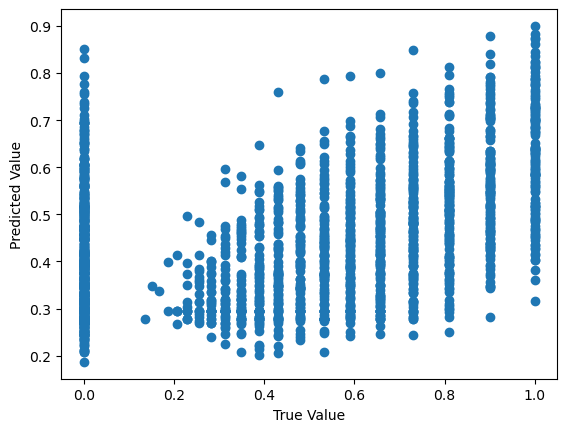

In [31]:
from matplotlib import pyplot as plt

plt.scatter(v_true, v_pred)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

Text(0, 0.5, 'Count')

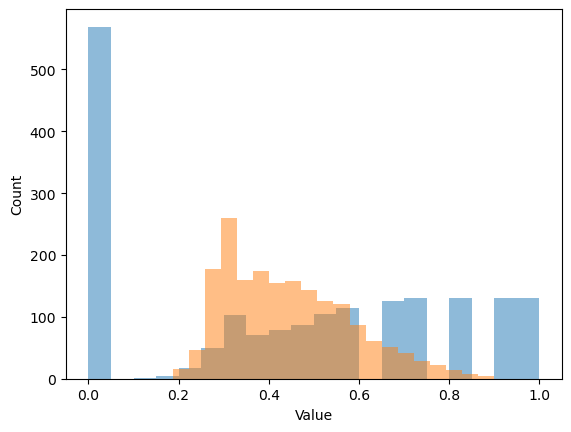

In [33]:
plt.hist(v_true, bins=20, alpha=0.5, label='True')
plt.hist(v_pred, bins=20, alpha=0.5, label='Predicted')
plt.xlabel("Value")
plt.ylabel("Count")

(array([  4.,   8.,  23.,  47.,  82., 107., 128., 162.,  31.,  73., 112.,
        167., 190., 204., 195., 143.,  97.,  49.,  23.,   4.]),
 array([-0.85052574, -0.773791  , -0.69705627, -0.62032154, -0.54358681,
        -0.46685208, -0.39011734, -0.31338261, -0.23664788, -0.15991315,
        -0.08317842, -0.00644368,  0.07029105,  0.14702578,  0.22376051,
         0.30049524,  0.37722998,  0.45396471,  0.53069944,  0.60743417,
         0.68416891]),
 <BarContainer object of 20 artists>)

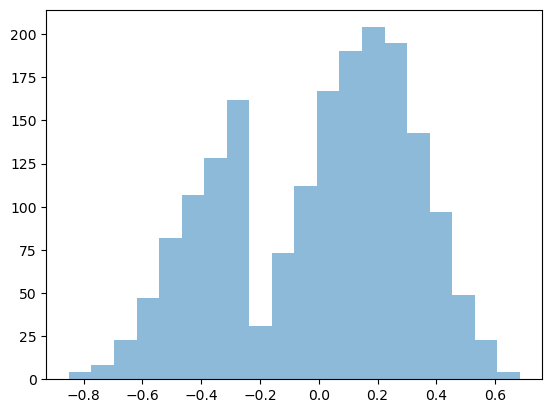

In [34]:
d_true = np.array(v_true) - np.array(v_pred)
plt.hist(d_true, bins=20, alpha=0.5, label='Difference')

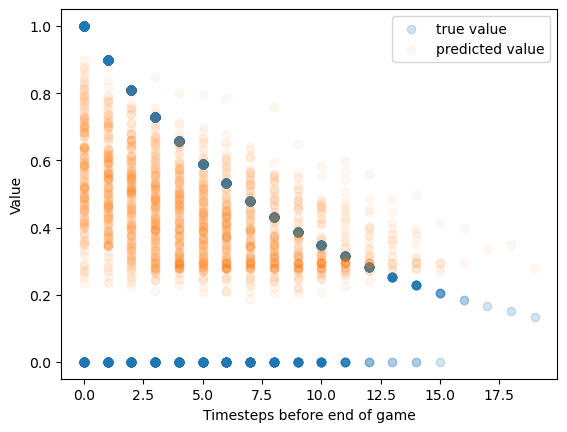

In [37]:
plt.scatter(t, v_true, alpha=0.2, label='true value')
plt.scatter(t, v_pred, alpha=0.05, label='predicted value')

plt.xlabel('Timesteps before end of game')
plt.ylabel('Value')
plt.legend()
